# Text Analytics: 5th Assignment (Part 2: Exercise 3)
## MSc in Data Science (2023/2024)

In [1]:
import tasks.preprocessing, tasks.models, tasks.tuning, tasks.util

import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os
import gc

2024-03-08 20:03:41.160670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:03:41.160894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 20:03:41.237912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 20:03:41.407134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 20:03:43.089472: W tensorflow/compiler/tf2

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

INPUT_DIR = "input"
INPUT_MODEL_PATH = os.path.join(INPUT_DIR, "models")
OUTPUT_DIR = "output"
INTERMEDIATE_DIR = "intermediate"

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print("Executing with ", gpus[0].name if len(gpus) != 0 else "CPU")

Executing with  /physical_device:GPU:0


2024-03-08 20:03:45.196248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 20:03:45.550503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 20:03:45.551727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Dataset

Acquiring and preprocessing our data with the goal of eventually acquiring a sufficient representation of our text is the most difficult and time-consuming task. We thus split it in distinct phases:

* Original dataset acquisition and parsing
* Qualitative analysis and preprocessing
* Transformation for the NLP task

Note that due to the relative custom code complexity, most of the code used in this section was developed and imported from python source files located in the `tasks` module. In-depth documentation and implementation details can be found in these files. 

In [4]:
print("Loading training dataset...")
train_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-train.conllu"
)
print("Loading validation dataset...")
val_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-dev.conllu"
)
print("Loading test dataset...")
test_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-test.conllu"
)

print(
    f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}"
    "\nTest data shape: {test_df.shape}"
)

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2001 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2077 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (25511, 3)
Test data shape: {test_df.shape}


Below we can see a preview of our parsed training dataset. Our preprocessing exploits pandas's ordering scheme in order to make sure the words are inserted in the order they appear in the sentence. This ordering will prove important later.

In [5]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


As mentioned above, our dataset features words connected with punctuation such as "don't". These are normally treated as two words, with the first being their intuitive POS tag ("do" - AUX) and the second as part of the first ("n't" - PART).

This dataset contains both the full words and their split versions, with only the latter featuring valid POS tags. The former are instead marked by a pseudo-tag (here "_").

In [6]:
invalid_idx = train_df.pos == "_"
train_df[invalid_idx]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
704,won't,_,weblog-juancole.com_juancole_20051126063000_EN...
868,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1058,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1078,doesn't,_,weblog-blogspot.com_healingiraq_20040409053012...
...,...,...,...
207078,couldn't,_,reviews-319816-0025
207091,don't,_,reviews-319816-0025
207096,employees',_,reviews-319816-0025
207164,i'm,_,reviews-319816-0027


In [7]:
" ".join(train_df[invalid_idx].words.unique()[:30])

"don't won't doesn't haven't didn't others it's elena's women's children's i'm people's musharraf's sharon's hamas's right's cannot isn't one's let's reporter's he's that's pakistan's world's bush's military's sharif's can't couldn't"

Below we can see an example of a word being contained both times in the dataset, one in full with the pseudo-tag, and the other as split words with valid POS tags.

In [8]:
train_df.iloc[176:179]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
177,do,AUX,weblog-juancole.com_juancole_20051126063000_EN...
178,n't,PART,weblog-juancole.com_juancole_20051126063000_EN...


We thus remove the full words including the pseudo-tag from our datasets, ensuring that all target POS tags will be compliant with the UPOS scheme.

In [9]:
train_df = train_df[~invalid_idx]
val_df = val_df[val_df.pos != "_"]
test_df = test_df[test_df.pos != "_"]

### Qualitative Analysis

We analyze our dataset in two granualities: sentences and individual words. We begin by analyzing how many words are in each sentence, which will give us an idea on the size of context available for each word.

In [10]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words


train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

Figure saved to output/ex_2_dataset_stats.png


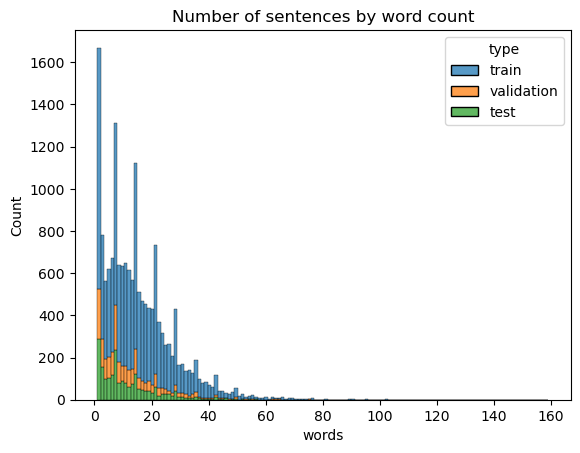

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
tasks.util.save_plot("ex_2_dataset_stats.png", OUTPUT_DIR)
plt.show()

As we can see from the graph above, there is a sizable portion of our sentences that feature very few words. In order to make the RNN training more efficient, we choose to discard sentences with very few words.

In [12]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [13]:
MIN_SENTENCE_LENGTH = 5

train_df = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

In [14]:
train_length.describe()

count    10539.000000
mean        18.967170
std         11.782365
min          5.000000
25%         10.000000
50%         16.000000
75%         24.000000
max        159.000000
Name: words, dtype: float64

In [15]:
val_length.describe()

count    1538.000000
mean       15.607932
std        10.050704
min         5.000000
25%         8.000000
50%        13.000000
75%        20.000000
max        75.000000
Name: words, dtype: float64

In [16]:
test_length.describe()

count    1535.000000
mean       15.512052
std        10.332400
min         5.000000
25%         8.000000
50%        13.000000
75%        20.000000
max        81.000000
Name: words, dtype: float64

In [17]:
vocab_size = len(set(train_df.words))
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 15967


In [18]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

Total word count:
Training: 199895
Validation: 24005
Testing: 23811


In [19]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

Total sentence count:
Training: 10539
Validation: 1538
Testing: 1535


### Vectorization

In order to make the RNN training more efficient, we choose to discard sentences with very few words. We also set a window size equal to the 90\% percentile of sentence word count, meaning tht 90\% of our windows will fully fit the training sentences. The rest will be automatically split into more sentences, and as such don't need to be excluded from the dataset.

In [20]:
MAX_SEQUENCE_LENGTH = int(np.quantile(train_length, 0.9))
MAX_SEQUENCE_LENGTH

34

We will be using a combination of the `keras.preprocessing.Tokenizer` and `keras.utils.pad_sequences` utilities to create custom windows of words to be fed to our model, since it uses Time Distributed outputs. 

In [21]:
def encode(tokenizer, values):
    return tokenizer.texts_to_sequences(values)


def encode_with_padding(tokenizer, max_seq_len, values):
    tokens = encode(tokenizer, values)
    padded_tokens = keras.utils.pad_sequences(
        tokens, maxlen=max_seq_len, padding="pre", truncating="post"
    )
    return padded_tokens


def decode(tokenizer, encoded_sequence, axis=2):
    return np.array(
        [
            tokenizer.index_word[str(x[-1])]
            for x in np.argmax(encoded_sequence, axis=axis)
        ]
    )

In [22]:
# encode X
word_tokenizer = keras.preprocessing.text.Tokenizer(filters="")
word_tokenizer.fit_on_texts(train_df.words.values)

train_data = encode_with_padding(
    word_tokenizer, MAX_SEQUENCE_LENGTH, train_df.words.values
)
val_data = encode_with_padding(
    word_tokenizer, MAX_SEQUENCE_LENGTH, val_df.words.values
)
test_data = encode_with_padding(
    word_tokenizer, MAX_SEQUENCE_LENGTH, test_df.words.values
)

tag_tokenizer = keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(train_df.pos.values)

# start label counting from 0, since to_categorical assumes argmax = number_of_categories
tag_tokenizer.word_index = {
    key: value - 1 for key, value in tag_tokenizer.word_index.items()
}

# start label counting from 0, since to_categorical assumes argmax = number_of_categories
tag_tokenizer.index_word = {
    str(int(key) - 1): value for key, value in tag_tokenizer.index_word.items()
}

y_train = keras.utils.to_categorical(
    encode_with_padding(tag_tokenizer, MAX_SEQUENCE_LENGTH, train_df.pos.values)
)
y_valid = keras.utils.to_categorical(
    encode_with_padding(tag_tokenizer, MAX_SEQUENCE_LENGTH, val_df.pos.values)
)
y_test = keras.utils.to_categorical(
    encode_with_padding(tag_tokenizer, MAX_SEQUENCE_LENGTH, test_df.pos.values)
)

In [23]:
# check that counting is continuous starting from 0
tag_tokenizer.word_index

{'noun': 0,
 'punct': 1,
 'verb': 2,
 'pron': 3,
 'adp': 4,
 'det': 5,
 'adj': 6,
 'aux': 7,
 'propn': 8,
 'adv': 9,
 'cconj': 10,
 'part': 11,
 'sconj': 12,
 'num': 13,
 'sym': 14,
 'intj': 15,
 'x': 16}

In [24]:
# input shape
y_train.shape

(199895, 34, 17)

## Baseline Model

In [25]:
from tasks.models import BaselineLabelClassifier


x_base_train = train_df.words
x_base_valid = val_df.words
x_base_test = test_df.words

y_base_train = train_df.pos
y_base_valid = val_df.pos
y_base_test = test_df.pos

base_cls = BaselineLabelClassifier()
base_cls.fit(X=x_base_train, y=y_base_train)

BaselineLabelClassifier()

In [26]:
from sklearn.metrics import classification_report


training_preds = base_cls.predict(x_base_train)
print(classification_report(y_base_train, training_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.89      0.89     12854
         ADP       0.88      0.67      0.76     17732
         ADV       0.61      0.83      0.70      9995
         AUX       0.88      0.78      0.83     12746
       CCONJ       0.98      0.99      0.99      6656
         DET       0.96      0.95      0.95     16228
        INTJ       0.65      0.86      0.74       572
        NOUN       0.88      0.90      0.89     34011
         NUM       0.99      0.88      0.93      3753
        PART       0.71      0.89      0.79      5734
        PRON       0.90      0.95      0.92     18479
       PROPN       0.89      0.83      0.86     11289
       PUNCT       0.99      0.99      0.99     22574
       SCONJ       0.64      0.42      0.50      3836
         SYM       0.89      0.83      0.86       668
        VERB       0.83      0.89      0.86     22363
           X       0.82      0.58      0.68       405

    accuracy              

In [27]:
test_preds = base_cls.predict(x_base_test)
print(classification_report(y_base_test, test_preds))

              precision    recall  f1-score   support

         ADJ       0.88      0.82      0.85      1666
         ADP       0.89      0.67      0.76      2013
         ADV       0.62      0.83      0.71      1131
         AUX       0.89      0.78      0.83      1521
       CCONJ       0.99      0.98      0.99       726
         DET       0.96      0.95      0.96      1870
        INTJ       0.66      0.73      0.69        86
        NOUN       0.67      0.89      0.77      3909
         NUM       0.96      0.55      0.70       485
        PART       0.70      0.90      0.78       632
        PRON       0.91      0.95      0.93      2118
       PROPN       0.88      0.48      0.62      1753
       PUNCT       0.99      0.98      0.99      2794
       SCONJ       0.60      0.44      0.51       382
         SYM       0.82      0.86      0.84       101
        VERB       0.80      0.82      0.81      2544
           X       0.00      0.00      0.00        80

    accuracy              

## MLP Classifier

The model we use is the pre-trained optimal model used in the previous assignment. We follow the same preprocessing and caching steps as in the previous assignment. Since the model is not trained again, we use only a subset of the original training data (25,000 windows) in order to save on scare main-memory resources. We consider this a representative sample for comparison with other classifiers due to the sample size (law of large numbers).


In [28]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [29]:
WINDOW_SIZE = 5
# training data are used exclusively for training accuracy, thus
# we only need a small, representative sample
TRAINING_LIM = 25000
VALID_LIM = 25000
TEST_LIM = 10000
SEED = 42
PAD_TOKEN = "<PAD>"

In [30]:
# download and unzip only if the download and unzipped files do not exist 
!wget -nc -P input/fasttext https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

![ -f "input/fasttext/cc.en.300.bin" ] && echo "Skipping model file" || gzip --decompress --keep --force "input/fasttext/cc.en.300.bin.gz"   

File ‘input/fasttext/cc.en.300.bin.gz’ already there; not retrieving.

Skipping model file


In [31]:
import fasttext


print("Loading embedding model...")
fasttext_model = fasttext.load_model("input/fasttext/cc.en.300.bin")

Loading embedding model...


In [32]:
(
    x_train_mlp,
    x_valid_mlp,
    x_test_mlp,
    y_train_mlp,
    y_valid_mlp,
    y_test_mlp,
    lb_mlp,
) = tasks.preprocessing.mlp_input(
    train_df,
    val_df,
    test_df,
    embed_model=fasttext_model,
    intermediate_dir=INTERMEDIATE_DIR,
    train_lim=TRAINING_LIM,
    val_lim=VALID_LIM,
    test_lim=TEST_LIM,
    window_size=WINDOW_SIZE,
    seed=SEED,
    pad_token=PAD_TOKEN,
)

del fasttext_model

Attempting to load intermediate calculations...
Loaded cached calculations.


## RNN Model

## CNN Model

## Transformers

In [33]:
import datasets
import transformers
import torch


def encode_bert(df, col_name):
    sentences = []

    for sentence_id in tqdm(set(df.sent_id)):
        words_df = df[df.sent_id == sentence_id]
        sentence = list(words_df[col_name])
        sentences.append(sentence)

    return sentences


print("Converting dataframe to individual sentences...")
data_dict = datasets.DatasetDict(
    {
        "train": datasets.Dataset.from_dict(
            {
                "labels": tag_tokenizer.texts_to_sequences(
                    encode_bert(train_df, "pos")
                ),
                "words": encode_bert(train_df, "words"),
            }
        ),
        "val": datasets.Dataset.from_dict(
            {
                "labels": tag_tokenizer.texts_to_sequences(
                    encode_bert(val_df, "pos")
                ),
                "words": encode_bert(val_df, "words"),
            }
        ),
        "test": datasets.Dataset.from_dict(
            {
                "labels": tag_tokenizer.texts_to_sequences(
                    encode_bert(test_df, "pos")
                ),
                "words": encode_bert(test_df, "words"),
            }
        ),
    }
)
data_dict

Converting dataframe to individual sentences...


  0%|          | 0/10539 [00:00<?, ?it/s]

  0%|          | 0/10539 [00:00<?, ?it/s]

  0%|          | 0/1538 [00:00<?, ?it/s]

  0%|          | 0/1538 [00:00<?, ?it/s]

  0%|          | 0/1535 [00:00<?, ?it/s]

  0%|          | 0/1535 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'words'],
        num_rows: 10539
    })
    val: Dataset({
        features: ['labels', 'words'],
        num_rows: 1538
    })
    test: Dataset({
        features: ['labels', 'words'],
        num_rows: 1535
    })
})

In [34]:
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(
    "distilbert/distilbert-base-uncased", use_fast=True
)

model = transformers.AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    torch_dtype=torch.float16,
    num_labels=len(train_df.pos.unique()),
).to("cuda")

# "TweebankNLP/bertweet-tb2_ewt-pos-tagging"
# "bert-base-uncased"

model

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [35]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = bert_tokenizer(
        examples["words"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=MAX_SEQUENCE_LENGTH,
    )

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(
            batch_index=i
        )  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif (
                word_idx != previous_word_idx
            ):  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


tokenized_data_dict = data_dict.map(tokenize_and_align_labels, batched=True)
tokenized_data_dict

Map:   0%|          | 0/10539 [00:00<?, ? examples/s]

Map:   0%|          | 0/1538 [00:00<?, ? examples/s]

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'words', 'input_ids', 'attention_mask'],
        num_rows: 10539
    })
    val: Dataset({
        features: ['labels', 'words', 'input_ids', 'attention_mask'],
        num_rows: 1538
    })
    test: Dataset({
        features: ['labels', 'words', 'input_ids', 'attention_mask'],
        num_rows: 1535
    })
})

In [36]:
data_collator = transformers.DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [39]:
def decode_bert(encoded_sequence, num_classes):
    # create dummy class for -100 tokens
    return keras.utils.to_categorical(
        [x if x != -100 else num_classes for x in encoded_sequence.flatten()],
        num_classes=num_classes + 1,
    )


def compute_metrics(pred):
    labels = decode_bert(pred.label_ids, 17)
    preds = decode_bert(pred.predictions.argmax(-1), 17)

    # ignore dummy label
    mask = labels[:, -1] != 1
    labels = labels[mask]
    preds = preds[mask]

    # calculate accuracy using sklearn's function
    acc = sklearn.metrics.accuracy_score(labels, preds)
    precision = sklearn.metrics.precision_score(labels, preds, average="macro")
    recall = sklearn.metrics.recall_score(labels, preds, average="macro")
    f1 = sklearn.metrics.f1_score(labels, preds, average="macro")
    

    return {
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
    }

In [40]:
gc.collect()
torch.cuda.empty_cache()

training_args = transformers.TrainingArguments(
    output_dir=OUTPUT_DIR,  # output directory
    num_train_epochs=8,  # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,  # batch size for evaluation
    gradient_accumulation_steps=4,  # Number of update steps (forward passes) to accumulate the gradients for, before performing a backward/update pass
    weight_decay=0.01,  # strength of weight decay
    logging_dir="./logs",  # directory for storing logs
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    eval_steps=100,
    save_steps=100,
    evaluation_strategy=transformers.IntervalStrategy.STEPS,
    load_best_model_at_end=True,
     metric_for_best_model = "val_accuracy",
    save_total_limit=3,
)

trainer = transformers.Trainer(
    model=model,  # the instantiated Transformers model to be trained
    args=training_args,  # training arguments, as defined above
    train_dataset=tokenized_data_dict["train"],  # training dataset
    eval_dataset=tokenized_data_dict["val"],  # evaluation dataset
    tokenizer=bert_tokenizer,  # tokenizer
    data_collator=data_collator, # batch creator (padding)
    callbacks=[
        transformers.EarlyStoppingCallback(early_stopping_patience=5)
    ],  
    compute_metrics=compute_metrics    
)

# Start training
trainer.train()

  0%|          | 0/1312 [00:00<?, ?it/s]